## Importing Data

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42
                    )

In [3]:
len(X),len(y)

(1000, 1000)

In [4]:
X[:5],y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [5]:
import pandas as pd

circle = pd.DataFrame({'X1': X[:,0],
                       'X2': X[:,1],
                       'label':y
                       })
circle.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


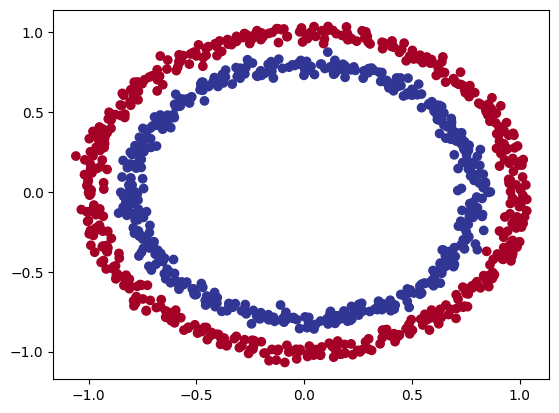

In [6]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap = plt.cm.RdYlBu
            );

In [7]:
X.shape,y.shape

((1000, 2), (1000,))

In [8]:
#1st sample

first_sample_x = X[0]
first_sample_y = y[0]

first_sample_x,first_sample_y

(array([0.75424625, 0.23148074]), 1)

In [9]:
first_sample_x.shape,first_sample_y.shape

((2,), ())

## Turning data into tensors

In [10]:
import torch

In [11]:
type(X)

numpy.ndarray

In [12]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [13]:
X.dtype,y.dtype

(torch.float32, torch.float32)

## split data into train and test set

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.8,
                                                    random_state=42)

In [15]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [16]:
n_samples

1000

## Building a model

Steps:
1. Set up device
2. Construct a model
3. Define loss fn and optimizer
4. Create train and test loop

### Set up device

In [17]:
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [18]:
X_train.shape

torch.Size([800, 2])

### Build a model

In [19]:
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(in_features=2,out_features=5) #Layer1 of neural network of input node 2 and hidden layer of node 5
    self.layer2 = nn.Linear(in_features=5, out_features=1)
    # we can crate multipla layer like this
    #self.multi_layer = nn.Sequential(
    #    nn.Linear(in_features=2, out_features=5),
    #    nn.Linear(in_features=5, out_features=1)
    #)

  def forward(self, x):
    #if we follow 2nd method here we use
    #return self.multi_layer(x)
    return self.layer2(self.layer1(x))


model = CircleModel().to(device)
model

CircleModel(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
#checking in which device our model is
next(model.parameters()).device

device(type='cpu')

In [21]:
#creating same above model using nn.Sequential

model1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [22]:
#lets just use model1
model1.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0292,  0.6236],
                      [ 0.2976, -0.5822],
                      [ 0.3770, -0.1524],
                      [-0.7065, -0.3163],
                      [ 0.7062, -0.3863]])),
             ('0.bias', tensor([-0.6212,  0.4108,  0.2084,  0.7023, -0.2113])),
             ('1.weight',
              tensor([[-0.1918, -0.4058, -0.3746,  0.3567,  0.2972]])),
             ('1.bias', tensor([-0.1117]))])

In [23]:
#make untrained prediction
with torch.inference_mode():
  untrain_pred = model1(X_test.to(device))
untrain_pred[:10]

tensor([[ 0.0257],
        [-0.1058],
        [ 0.1772],
        [-0.0164],
        [-0.1297],
        [-0.2076],
        [-0.3347],
        [-0.3593],
        [ 0.1899],
        [-0.1181]])

### Build loss fn and optimizer

In [24]:
# set up loss fn
#loss_fn = nn.BCELOSS() # loss fn without sigmoid build in fn
'''
nn.Sequential(
    nn.Sigmoidal(),
    nn.BCELoss()
)
#This code is equivalent with nn.BCEWithLogitsLoss()
'''

loss_fn = nn.BCEWithLogitsLoss() # class with built in sigmoid activation fn
'''This version is more numerically stable than using a plain Sigmoid
followed by a BCELoss as, by combining the operations into one layer,
we take advantage of the log-sum-exp trick for numerical stability.'''

optimizer = torch.optim.SGD(params=model1.parameters(),
                            lr=0.1
                            ) #passing parameters will be update by SGD

In [25]:
model1.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0292,  0.6236],
                      [ 0.2976, -0.5822],
                      [ 0.3770, -0.1524],
                      [-0.7065, -0.3163],
                      [ 0.7062, -0.3863]])),
             ('0.bias', tensor([-0.6212,  0.4108,  0.2084,  0.7023, -0.2113])),
             ('1.weight',
              tensor([[-0.1918, -0.4058, -0.3746,  0.3567,  0.2972]])),
             ('1.bias', tensor([-0.1117]))])

In [26]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

### Train Model

1. forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward(Backpropagation)
5. Optimizer step

#### Going from raw logits -> prediction probabilities -> prediction labels

In [27]:
y_logits = model1(X_test.to(device))
y_logits[:5]

tensor([[ 0.0257],
        [-0.1058],
        [ 0.1772],
        [-0.0164],
        [-0.1297]], grad_fn=<SliceBackward0>)

In [28]:
#to turn off gradient tracking
model1.eval()
with torch.inference_mode():
  y_logits = model1(X_test.to(device))

#comparing predict to orginal
y_logits[:5], y_test[:5]

(tensor([[ 0.0257],
         [-0.1058],
         [ 0.1772],
         [-0.0164],
         [-0.1297]]),
 tensor([1., 0., 1., 0., 1.]))

In [29]:
#pass y_logits from sigmoid activation fn to turn them into
#prediction probabilities

y_logits_probs = torch.sigmoid(y_logits)
y_logits_probs[:5]

tensor([[0.5064],
        [0.4736],
        [0.5442],
        [0.4959],
        [0.4676]])

In [30]:
# finding prediction labels
y_predss = torch.round(y_logits_probs)
y_predss[:5]

tensor([[1.],
        [0.],
        [1.],
        [0.],
        [0.]])

In [31]:
# all 3 step can be done like this
model1.eval()
with torch.inference_mode():
 y_preds_labels = torch.round(torch.sigmoid(model1(X_test.to(device))))
y_preds_labels[:5]

tensor([[1.],
        [0.],
        [1.],
        [0.],
        [0.]])

#### train loop

In [32]:
torch.manual_seed(42)

epochs = 200

X_train , y_train = X_train.to(device), y_train.to(device)
X_test , y_test = X_test.to(device), y_test.to(device)

for epoc in range(epochs):
  #training
  model1.train()

  #forward pass
  y_logits = model1(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  #calculate loss/accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), #nn.BCELoss expects prediction probabilities as input
  #                y_preds
  #                )


  loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
                 y_preds)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_preds
                    )

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. loss backward (backpropagation)
  loss.backward()

  # 5. optimizer step (gradient descent)
  optimizer.step()

  #testing
  model1.eval()
  with torch.inference_mode():
    # 1. forward pass
    test_logits = model1(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    # 2. calculate loss/acc
    test_loss = loss_fn(test_logits,
                        test_preds
                        )
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred= test_preds
                           )

    if epoc % 10 == 0:
      print(f'Epoch:{epoc} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%')

Epoch:0 | Loss: 0.61012, Acc: 49.00% | Test Loss: 0.59978, Test Acc: 51.00%
Epoch:10 | Loss: 0.50609, Acc: 50.25% | Test Loss: 0.50087, Test Acc: 49.50%
Epoch:20 | Loss: 0.40969, Acc: 50.00% | Test Loss: 0.41010, Test Acc: 50.50%
Epoch:30 | Loss: 0.33198, Acc: 50.62% | Test Loss: 0.33816, Test Acc: 50.00%
Epoch:40 | Loss: 0.27336, Acc: 50.62% | Test Loss: 0.28456, Test Acc: 50.50%
Epoch:50 | Loss: 0.23062, Acc: 51.00% | Test Loss: 0.24548, Test Acc: 49.50%
Epoch:60 | Loss: 0.19918, Acc: 50.75% | Test Loss: 0.21669, Test Acc: 50.00%
Epoch:70 | Loss: 0.17578, Acc: 50.62% | Test Loss: 0.19518, Test Acc: 50.00%
Epoch:80 | Loss: 0.15794, Acc: 50.88% | Test Loss: 0.17882, Test Acc: 50.00%
Epoch:90 | Loss: 0.14387, Acc: 50.88% | Test Loss: 0.16590, Test Acc: 50.00%
Epoch:100 | Loss: 0.13256, Acc: 50.50% | Test Loss: 0.15564, Test Acc: 49.50%
Epoch:110 | Loss: 0.12313, Acc: 50.50% | Test Loss: 0.14739, Test Acc: 49.00%
Epoch:120 | Loss: 0.11528, Acc: 50.50% | Test Loss: 0.14024, Test Acc: 48.5

## Lets plot

## improving our model

1. add more layer
2. add hidden nodes
3. fit for longer
4. changing the activation fn
5. change the learning rate

## 6. Missing Piece: Non-linearity

* what pattern you can draw if you get infinite no ( n no of epoch ) of straight and non-straight line

### 6.1 Recreating non-linear data

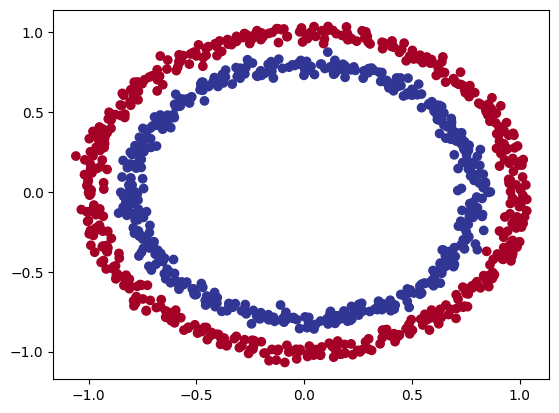

In [33]:
# making data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42
                    )

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [34]:
# converting data to tensors and into train test split

import torch
from sklearn.model_selection import train_test_split

#turn data type into tensor
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

print(f'X_train: {X_train[:5]} | X_train Shape: {X_train.shape}')
print(f'y_train: {y_train[:5]} | y_train Shape: {y_train.shape}')

X_train: tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        [-0.9666, -0.2256],
        [-0.1666,  0.7994]]) | X_train Shape: torch.Size([800, 2])
y_train: tensor([1., 0., 0., 0., 1.]) | y_train Shape: torch.Size([800])


### Buiding non-linear model

1. linear = straight
2. non-linear = non-straight

In [35]:
from torch import nn

class CircleModelv2(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() #non-linear activation fn

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


non_linear_model = CircleModelv2().to(device)
non_linear_model

CircleModelv2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [36]:
non_linear_model.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1

### setting up loss_fn, optimizer and training our model

In [37]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(non_linear_model.parameters(), lr=0.01)

In [38]:
device

'cpu'

In [39]:
torch.manual_seed(42)
epocs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoc in range(epocs):
  ### train mode
  non_linear_model.train()

  #forward pass
  y_logits = non_linear_model(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  #loss and accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

  #optimizer zero grad
  optimizer.zero_grad()

  #backpropagation
  loss.backward()

  #optimizer step
  optimizer.step()

  ### testing mode
  non_linear_model.eval()
  with torch.inference_mode():
    #forward pass
    test_logits = non_linear_model(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    #loss and accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true= y_test, y_pred=test_preds)

    if epoc % 10 == 0:
      print(f"Epoch: {epoc} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69325, Test Accuracy: 50.00%
Epoch: 10 | Loss: 0.69289, Accuracy: 50.00% | Test Loss: 0.69318, Test Accuracy: 50.00%
Epoch: 20 | Loss: 0.69284, Accuracy: 50.00% | Test Loss: 0.69311, Test Accuracy: 50.00%
Epoch: 30 | Loss: 0.69279, Accuracy: 50.00% | Test Loss: 0.69305, Test Accuracy: 50.00%
Epoch: 40 | Loss: 0.69273, Accuracy: 50.00% | Test Loss: 0.69298, Test Accuracy: 50.00%
Epoch: 50 | Loss: 0.69268, Accuracy: 50.00% | Test Loss: 0.69291, Test Accuracy: 50.00%
Epoch: 60 | Loss: 0.69264, Accuracy: 50.00% | Test Loss: 0.69285, Test Accuracy: 50.00%
Epoch: 70 | Loss: 0.69259, Accuracy: 50.00% | Test Loss: 0.69279, Test Accuracy: 50.00%
Epoch: 80 | Loss: 0.69255, Accuracy: 50.00% | Test Loss: 0.69274, Test Accuracy: 50.00%
Epoch: 90 | Loss: 0.69251, Accuracy: 50.38% | Test Loss: 0.69269, Test Accuracy: 50.00%


## Putting all things together by using multi-class classification

In [40]:
#import dependency
import torch
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [41]:

# set hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

In [42]:
#creating multiclass data

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features= NUM_FEATURES,
                            centers= NUM_CLASSES,
                            cluster_std = 1.5, #give cluster little shake up
                            random_state= RANDOM_SEED
                            )

# convert data into tensor
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

#train test split
X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob,
                                                    train_size=0.8,
                                                    random_state=RANDOM_SEED
                                                    )

In [43]:
X_train[:5],y_train[:5]

(tensor([[ 5.0405,  3.3076],
         [-2.6249,  9.5260],
         [-8.5240, -9.0402],
         [-6.0262, -4.4375],
         [-3.3397,  7.2175]]),
 tensor([1, 0, 2, 2, 0]))

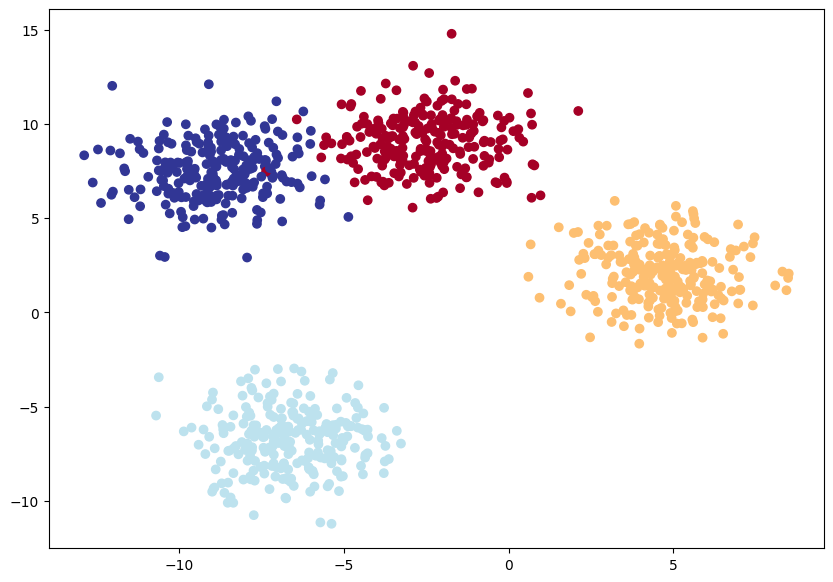

In [44]:
# plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

### Building multiclass classification model

In [45]:
#create a device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [46]:
y_test.unique()

tensor([0, 1, 2, 3])

In [47]:
#building a multiclass classification model

class BlobsClassificationv1(nn.Module):
  def __init__(self, input_features, output_features, hidden_unit = 8):
    super().__init__()

    self.linear_stack_layer = nn.Sequential(
        nn.Linear(in_features= input_features, out_features= hidden_unit),
        nn.ReLU(),
        nn.Linear(in_features= hidden_unit, out_features= hidden_unit),
        nn.ReLU(),
        nn.Linear(in_features= hidden_unit, out_features= output_features)
    )

  def forward(self, x):
    return self.linear_stack_layer(x)

In [48]:
blob_model = BlobsClassificationv1(
    input_features=2,
    output_features=4,
    hidden_unit=8
).to(device)

blob_model

BlobsClassificationv1(
  (linear_stack_layer): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [49]:
# loss and optimizer

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    params=blob_model.parameters(),
    lr = 0.1
)

In [50]:
blob_model.eval()
with torch.inference_mode(): #torch.inference_mode()
 print(blob_model(X_test.to(device))[:5])


tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]])


In [51]:
y_test, y_test.shape

(tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
         2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
         0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
         3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
         1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
         2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
         2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
         2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
         1, 3, 2, 0, 3, 1, 2, 1]),
 torch.Size([200]))

### tain and test loop

In [52]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  blob_model.train()

  #forward pass
  y_logits = blob_model(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  #loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred= y_pred)

  #optimizer zero grad
  optimizer.zero_grad()

  # backpropagation
  loss.backward()

  # optimizer step
  optimizer.step()

  blob_model.eval()
  with torch.inference_mode():
    #forward pass
    test_logits = blob_model(X_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    #loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true= y_test, y_pred= test_preds)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.15883, Accuracy: 40.38% | Test Loss: 1.07554, Test Accuracy: 48.00%
Epoch: 10 | Loss: 0.64476, Accuracy: 96.75% | Test Loss: 0.66069, Test Accuracy: 97.50%
Epoch: 20 | Loss: 0.42535, Accuracy: 98.50% | Test Loss: 0.43074, Test Accuracy: 100.00%
Epoch: 30 | Loss: 0.25294, Accuracy: 99.12% | Test Loss: 0.24508, Test Accuracy: 99.50%
Epoch: 40 | Loss: 0.11232, Accuracy: 99.25% | Test Loss: 0.10229, Test Accuracy: 99.50%
Epoch: 50 | Loss: 0.06627, Accuracy: 99.25% | Test Loss: 0.05848, Test Accuracy: 99.50%
Epoch: 60 | Loss: 0.05068, Accuracy: 99.25% | Test Loss: 0.04293, Test Accuracy: 99.50%
Epoch: 70 | Loss: 0.04300, Accuracy: 99.25% | Test Loss: 0.03491, Test Accuracy: 99.50%
Epoch: 80 | Loss: 0.03836, Accuracy: 99.25% | Test Loss: 0.02988, Test Accuracy: 99.50%
Epoch: 90 | Loss: 0.03525, Accuracy: 99.25% | Test Loss: 0.02663, Test Accuracy: 99.50%


In [53]:
#make prediction
blob_model.eval()
with torch.inference_mode():
  y_logits = blob_model(X_test)

#viewing 1st 10 prediction
y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]])

In [54]:
# from logits to prediction probabilities
y_pred_prod = torch.softmax(y_logits, dim=1)
y_pred_prod[:10]

tensor([[1.3437e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
        [9.9825e-01, 1.4575e-03, 1.5997e-05, 2.7210e-04]])

In [55]:
# from pred prob to pred labels
y_preds = torch.argmax(y_pred_prod, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [56]:
y_test, y_preds

(tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
         2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
         0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
         3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
         1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
         2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
         2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
         2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
         1, 3, 2, 0, 3, 1, 2, 1]),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
         2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
         0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
         3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3,

In [57]:
y_test == y_preds

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, 

In [59]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

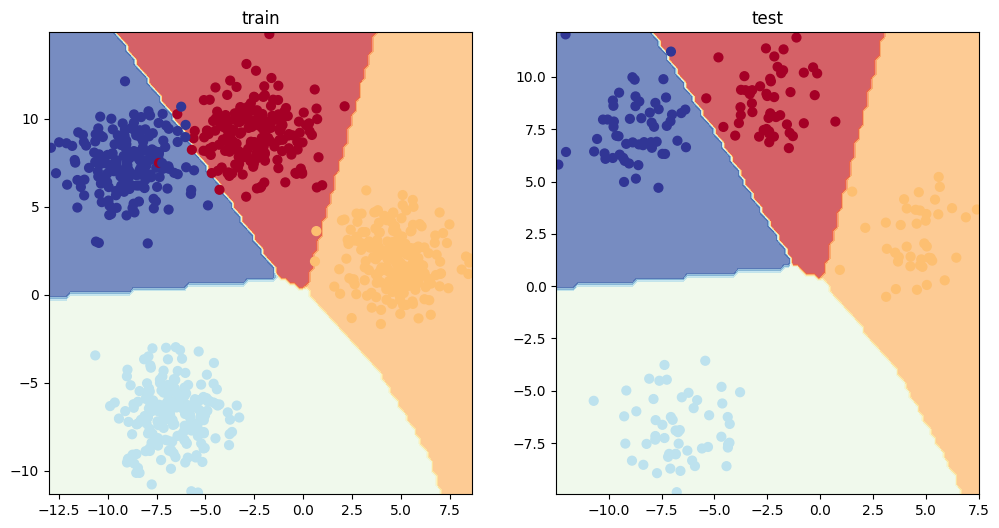

In [61]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title('train')
plot_decision_boundary(blob_model, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title('test')
plot_decision_boundary(blob_model, X_test, y_test)